# CORSID result figures

## Load ground truth

In [1]:
import pandas as pd
import numpy as np
import pysam
import matplotlib.pyplot as plt
from matplotlib import gridspec
import glob
import json
import seaborn as sns
from matplotlib_venn import venn2, venn3, venn3_unweighted, venn2_unweighted

In [2]:
%config InlineBackend.figure_formats = ['png']

In [3]:
df_gt_leader = pd.read_csv("ground_truth/gt_leader.csv").set_index("sample")

Specially, remove 2 samples with empty GTF annotation from comparison:
- DQ288927
- EU526388

In [4]:
df_gt_leader.loc["DQ288927", "pos"] = np.nan
df_gt_leader.loc["EU526388", "pos"] = np.nan

In [5]:
df_gt_leader_range = pd.read_csv("ground_truth/gt_leader_range.csv").set_index("sample")

In [6]:
with open("ground_truth/gt_regions.json") as ifile:
    gt_regions = json.load(ifile)

In [7]:
with open("ground_truth/gt_orf1ab.json") as ifile:
    gt_orf1ab = json.load(ifile)

### Correct misclassified samples

SuPER misclassify sample NC_016996 as _Moordecovirus_, it should be _Buldecovirus_ according to our analysis as well as annotation in GenBank: https://www.ncbi.nlm.nih.gov/nuccore/NC_016996 .
More specifically, _Moordecovirus_ is a canceled taxonomy which is merged into _Buldecovirus_ in 2019 release.

https://journals.asm.org/doi/full/10.1128/JVI.06540-11

In [8]:
df_gt_leader.loc["NC_016996", "subgenus"] = "Buldecovirus"

## CORSID-A figures

In [9]:
def get_corsid_annot_df(pattern):
    files = glob.glob(pattern)
    our_annot = {}
    for file in files:
        sample = file.split("/")[-1].split(".")[0]
        with open(file) as ifile:
            res = json.load(ifile)
            our_annot[sample] = res["results"]
    data = []
    for sample, s in our_annot.items():
        if len(s) == 0:
            data.append([sample, None, None, None, None, None])
            continue
        TP = len(s[0]["recall_ORF"])
        FN = len(s[0]["missing_ORF"])
        FP = s[0]["n_intervals"] - len(s[0]["recall_ORF"])
        data.append([sample, TP, FN, FP, s[0]["TRS_L_seq"], s[0]["weight"], s[0]["leader_core_start"]])
    df = pd.DataFrame(data, columns=["sample", "TP", "FN", "FP", "TRS_L", "max_weight", "leader"])
    df["gt_leader"] = df_gt_leader.loc[df["sample"], "pos"].values
    df["gt_range_start"] = df_gt_leader_range.loc[df["sample"], "start"].values
    df["gt_range_end"] = df_gt_leader_range.loc[df["sample"], "end"].values
    df["genus"] = df_gt_leader.loc[df["sample"], "genus"].values
    df["subgenus"] = df_gt_leader.loc[df["sample"], "subgenus"].values
    df["dist"] = df["leader"] - df["gt_leader"]
    df["correct"] = df["dist"].apply(lambda x: np.NaN if x!=x else abs(x) <= 6)
    df["correct_range"] = df.apply(lambda x: np.NaN if x["gt_leader"]!=x["gt_leader"] else x["gt_range_start"] <= x["leader"] <= x["gt_range_end"], axis=1)
    df["precision"] = df["TP"] / (df["TP"] + df["FP"])
    df["recall"] = df["TP"] / (df["TP"] + df["FN"])
    df["F1"] = 2 / (1 / df["precision"] + 1 / df["recall"])
    df["incomplete"] = df["gt_leader"].isna()
    return df

In [10]:
df_corsid_annot = get_corsid_annot_df("../result/CORSID_A/*.json")

### Load SuPER

In [11]:
df_super_raw = pd.read_excel("../result/SuPER/Supplementary_Tables.xlsx", sheet_name=3, engine='openpyxl')
df_super_raw.rename(columns={"Unnamed: 4": "Leader seq", "Unnamed: 6": "Body seq", "Unnamed: 7": "Body"}, inplace=True)
df_super = df_super_raw[(~df_super_raw["Accession"].isna()) & (df_super_raw["Accession"] != "EPI_ISL_412977")].copy()
df_super.rename(columns={"Accession": "sample",
                         "Genus": "genus",
                         "Subgenus": "subgenus",
                         "TRS-L": "leader"}, inplace=True)
df_super["gt_leader"] = df_gt_leader.loc[df_super["sample"], "pos"].values
df_super["dist"] = df_super["leader"] - df_super["gt_leader"]
df_super["correct"] = df_super["dist"].apply(lambda x: np.NaN if x!=x else abs(x) <= 3)
df_super["incomplete"] = df_super["gt_leader"].isna()

In [12]:
d_super_body = {}
cur_sample = None
for _, row in df_super_raw.iterrows():
    if not pd.isna(row["Accession"]):
        cur_sample = row["Accession"]
        d_super_body[cur_sample] = {}
        if not pd.isna(row["Body"]):
            orf, pos = row["Body"].split(":")
            start, end = pos.split('-')
            d_super_body[cur_sample][orf] = (int(start)-1, int(end)-1, row["TRS-B"])
    elif cur_sample is not None:
        if not pd.isna(row["Body"]):
            orf, pos = row["Body"].split(":")
            start, end = pos.split('-')
            d_super_body[cur_sample][orf] = (int(start)-1, int(end)-1, row["TRS-B"])

In [13]:
def get_ref(file):
    fasta = pysam.Fastafile(file)
    return fasta.fetch(fasta.references[0])

def parse_attributes(attr: str):
    return dict(pair.split('=') for pair in attr.split(";") if len(pair) > 0)

def assign_orf(regions, start, end=None):
    for orf, pos in regions.items():
        if isinstance(pos, list):
            if end is None:
                if abs(pos[0] - start) <= 6:
                    return orf
            else:
                if abs(pos[0] - start) <= 3 and abs(pos[1] - end) <= 3:
                    return orf
        else:
            if end is None:
                if abs(pos - start) <= 6:
                    return orf
            else:
                if start - 6 <= pos <= end:
                    return orf
    return None

In [14]:
TP = []
FN = []
FP = []
for sample in df_super["sample"]:
    tp = 0
    predict = set()
    for name, (start, end, TRS_B) in d_super_body[sample].items():
        ref = get_ref(f"../data/fasta/{sample}.fasta")
        predict_ATG = ref.find("ATG", TRS_B+1)
        predict_2ATG = ref.find("ATG", predict_ATG+1)
        if assign_orf(gt_regions[sample], predict_ATG) is not None:
            predict.update([assign_orf(gt_regions[sample], predict_ATG)])
        elif assign_orf(gt_regions[sample], predict_2ATG) is not None:
            predict.update([assign_orf(gt_regions[sample], predict_2ATG)])
    tp = len(predict)
    TP.append(tp)
    FN.append(len(gt_regions[sample]) - tp)
    FP.append(len(d_super_body[sample]) - tp)
TP = np.array(TP)
FN = np.array(FN)
FP = np.array(FP)
df_super["TP"] = TP
df_super["FN"] = FN
df_super["FP"] = FP
df_super["precision"] = df_super["TP"] / (df_super["TP"] + df_super["FP"])
df_super["recall"] = df_super["TP"] / (df_super["TP"] + df_super["FN"])
df_super["F1"] = 2 / (1 / df_super["precision"] + 1 / df_super["recall"])

### Load MEME

In [15]:
from Bio.motifs import meme

In [16]:
def get_num_seq(fasta):
    with open(fasta) as ifile:
        data = ifile.read()
        return data.count('>')

In [17]:
files = glob.glob("../result/MEME/*/meme.xml")
d_meme_annot = {}
for file in files:
    sample = file.split("/")[-2].strip()
    with open(file) as ifile:
        try:
            record = meme.read(ifile)
        except KeyError:
            print(file)
        data = []
        for motif in record:
            for instance in motif.instances:
                data.append({
                    "seq": str(instance),
                    "start": instance.start,
                    "strand":  instance.strand,
                    "orf": instance.sequence_name,
                    "p": instance.pvalue,
                })
        if sample in d_meme_annot:
            print(sample)
        else:
            d_meme_annot[sample] = pd.DataFrame(data)

data = []
for sample in df_gt_leader.index:
    if sample not in d_meme_annot:
        data.append([sample,
                 df_gt_leader.loc[sample, "genus"],
                 df_gt_leader.loc[sample, "subgenus"],
                 np.nan,
                 np.nan,
                 np.nan,
                 np.nan,
                 np.nan,
                 df_gt_leader.loc[sample, "pos"],
                 df_gt_leader_range.loc[sample, "start"],
                 df_gt_leader_range.loc[sample, "end"]])
        continue

    df = d_meme_annot[sample]
    total = get_num_seq(f"../result/MEME/{sample}/{sample}.seg.fasta")
    if "Leader" in df["orf"].values:
        pos = df.loc[df["orf"] == "Leader", "start"].values[0]
        TP = len(df) - 1
        FN = total - len(df)
        FP = len(df) - TP - 1
        FN = total - len(df)
    else:
        pos = np.nan
        TP = len(df)
        FP = len(df) - TP
        FN = total - len(df)
    data.append([sample,
                 df_gt_leader.loc[sample, "genus"],
                 df_gt_leader.loc[sample, "subgenus"],
                 TP,
                 FN,
                 FP,
                 len(df.loc[0, "seq"]),
                 pos,
                 df_gt_leader.loc[sample, "pos"],
                 df_gt_leader_range.loc[sample, "start"],
                 df_gt_leader_range.loc[sample, "end"],])
df_meme_annot = pd.DataFrame(data, columns=["sample", "genus", "subgenus", "TP", "FN", "FP", "length", "leader", "gt_leader", "gt_range_start", "gt_range_end"])
df_meme_annot["dist"] = df_meme_annot["leader"] - df_meme_annot["gt_leader"]
df_meme_annot["correct"] = df_meme_annot["dist"].apply(lambda x: np.NaN if x!=x else abs(x) <= 6)
df_meme_annot["correct_range"] = df_meme_annot.apply(lambda x: np.NaN if x["gt_leader"]!=x["gt_leader"] else x["gt_range_start"] <= x["leader"] <= x["gt_range_end"], axis=1)
df_meme_annot["incomplete"] = df_meme_annot["gt_leader"].isna()
df_meme_annot["precision"] = df_meme_annot["TP"] / (df_meme_annot["TP"] + df_meme_annot["FP"])
df_meme_annot["recall"] = df_meme_annot["TP"] / (df_meme_annot["TP"] + df_meme_annot["FN"])
df_meme_annot["F1"] = 2 / (1 / df_meme_annot["precision"] + 1 / df_meme_annot["recall"])

../result/MEME/GQ427176/meme.xml
../result/MEME/MK581206/meme.xml


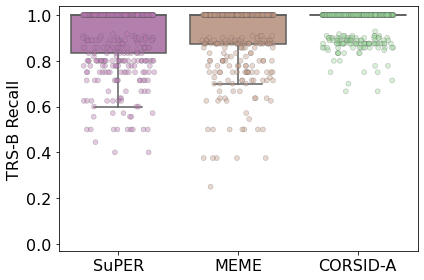

In [18]:
df_combine = pd.DataFrame({
    "correct": df_super.loc[(~df_super["incomplete"]), "correct"],
    "correct_range": df_super.loc[(~df_super["incomplete"]), "correct"],
    "recall": df_super.loc[(~df_super["incomplete"]), "recall"],
    "precision": df_super.loc[(~df_super["incomplete"]), "precision"],
    "F1": df_super.loc[(~df_super["incomplete"]), "F1"],
    "genus": df_super.loc[(~df_super["incomplete"]), "genus"],
    "method": "SuPER"
})
df_combine = pd.concat([df_combine, pd.DataFrame({
    "correct": df_meme_annot.loc[(~df_meme_annot["incomplete"]), "correct"],
    "correct_range": df_meme_annot.loc[(~df_meme_annot["incomplete"]), "correct_range"],
    "recall": df_meme_annot.loc[(~df_meme_annot["incomplete"]), "recall"],
    "precision": df_meme_annot.loc[(~df_meme_annot["incomplete"]), "precision"],
    "F1": df_meme_annot.loc[(~df_meme_annot["incomplete"]), "F1"],
    "genus": df_meme_annot.loc[(~df_meme_annot["incomplete"]), "genus"],
    "method": "MEME"
})], ignore_index=True)

df = df_corsid_annot
df_combine = pd.concat([df_combine, pd.DataFrame({
    "correct": df.loc[(~df["incomplete"]), "correct"],
    "correct_range": df.loc[(~df["incomplete"]), "correct_range"],
    "recall": df.loc[(~df["incomplete"]), "recall"],
    "precision": df.loc[(~df["incomplete"]), "precision"],
    "F1": df.loc[(~df["incomplete"]), "F1"],
    "genus": df.loc[(~df["incomplete"]), "genus"],
    "method": "CORSID-A",
})], ignore_index=True)

plt.figure(figsize=(6, 4))
ax = sns.boxplot(x="method", y="recall", data=df_combine, showfliers=False, palette=['#bb78b3', '#c79b86', '#9ad99a',])
ax = sns.stripplot(x="method", y="recall", data=df_combine, jitter=0.3, alpha=.4, linewidth=0.5, edgecolor="gray", palette=['#bb78b3', '#c79b86', '#9ad99a'])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
plt.yticks(fontsize=16)
ax.set_ylim((-0.03, None))
ax.set_ylabel("TRS-B Recall", fontsize=16)
ax.set_xlabel(None)
plt.tight_layout()

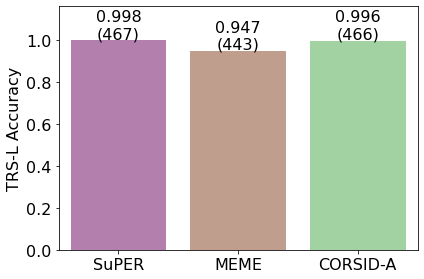

In [19]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(x="method", y="correct_range", data=df_combine, ci=None, palette=['#bb78b3', '#c79b86', '#9ad99a'])
grouped = df_combine.groupby("method")
for idx, method in enumerate(x.get_text() for x in ax.get_xticklabels()):
    n_correct = grouped.get_group(method)["correct_range"].sum()
    per_correct = n_correct / len(grouped.get_group(method)["correct_range"])
    ax.text(idx,
           grouped.get_group(method)["correct_range"].mean()+0.01,
           f"{per_correct:.3f}\n({n_correct})",
           color='black', ha="center", fontsize=16)
ax.set(ylim=(0, 1.16))
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
plt.yticks(fontsize=16)
ax.set_ylabel("TRS-L Accuracy", fontsize=16)
ax.set_xlabel(None)
plt.tight_layout()

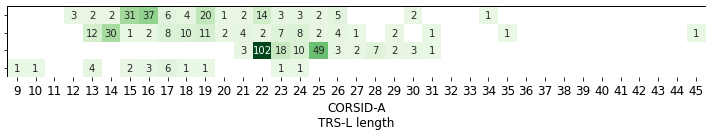

In [20]:
lmin = 9
lmax = 46
genus_list = ['Alphacoronavirus', 'Betacoronavirus', 'Gammacoronavirus', 'Deltacoronavirus']
length_counts = []
df_trsl = df_corsid_annot.loc[~df_corsid_annot["incomplete"], :]
# df_trsl["TRS-L len"] = df_trsl["TRS_L"].str.len()
for idx, genus in enumerate(genus_list):
    cnts = df_trsl[df_trsl['genus'] == genus]['TRS_L'].str.len().value_counts()
    length_counts.append([cnts[x] if x in cnts.keys() else 0 for x in range(lmin, lmax)])
length_counts = pd.DataFrame(length_counts, index=genus_list, columns=np.arange(9,46))
# length_counts = length_counts.loc[:, length_counts.sum(axis=0)]
fig, ax = plt.subplots(1,1,figsize=(10,2))
ax = sns.heatmap(length_counts, annot=True, xticklabels=True, yticklabels=True, cbar=False,
            vmin=-10,
            cmap='Greens', mask=length_counts == 0, fmt="d")
ax.set_yticklabels([])
plt.gca().set_xlabel('CORSID-A\nTRS-L length');
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.tight_layout()

ax.axhline(y=0, color='k',linewidth=1)
ax.axhline(y=np.array(length_counts).shape[0], color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
ax.axvline(x=np.array(length_counts).shape[1], color='k',linewidth=1)

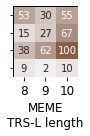

In [21]:
lmin = int(df_meme_annot["length"].min())
lmax = int(df_meme_annot["length"].max())+1
genus_list = ['Alphacoronavirus', 'Betacoronavirus', 'Gammacoronavirus', 'Deltacoronavirus']
length_counts = []
df_trsl = df_meme_annot.loc[~df_meme_annot["incomplete"], :]
for idx, genus in enumerate(genus_list):
    cnts = df_trsl[df_trsl['genus'] == genus]['length'].value_counts()
    length_counts.append([cnts[x] if x in cnts.keys() else 0 for x in range(lmin, lmax)])

fig, ax = plt.subplots(1,1,figsize=(1.2, 2))
my_cmap = sns.light_palette("#875c48", as_cmap=True)
sns.heatmap(np.array(length_counts), annot=True, xticklabels=True, yticklabels=True, cbar=False,
            cmap=my_cmap, mask=np.array(length_counts) == 0, fmt="d")
plt.gca().set_yticklabels([], rotation=0)
plt.gca().set_xticklabels(np.arange(lmin, lmax));
plt.gca().set_xlabel('MEME\nTRS-L length');
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.tight_layout()

ax.axhline(y=0, color='k',linewidth=1)
ax.axhline(y=np.array(length_counts).shape[0], color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
ax.axvline(x=np.array(length_counts).shape[1], color='k',linewidth=1)

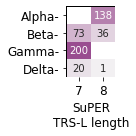

In [22]:
lmin = int(df_super["Leader seq"].str.len().min())
lmax = int(df_super["Leader seq"].str.len().max())+1
genus_list = ['Alphacoronavirus', 'Betacoronavirus', 'Gammacoronavirus', 'Deltacoronavirus']
length_counts = []
df_trsl = df_super.loc[~df_super["incomplete"], :]
for idx, genus in enumerate(genus_list):
    cnts = df_trsl[df_trsl['genus'] == genus]['Leader seq'].str.len().value_counts()
    length_counts.append([cnts[x] if x in cnts.keys() else 0 for x in range(lmin, lmax)])

fig, ax = plt.subplots(1,1,figsize=(1.8, 2))
#bb78b3', '#c79b86
my_cmap = sns.light_palette("#994d90", as_cmap=True)
sns.heatmap(np.array(length_counts), annot=True, xticklabels=True, yticklabels=True, cbar=False,
            cmap=my_cmap, mask=np.array(length_counts) == 0, fmt="d")
plt.gca().set_yticklabels(['Alpha-', 'Beta-', 'Gamma-', 'Delta-'], rotation=0)
plt.gca().set_xticklabels(np.arange(lmin, lmax));
plt.gca().set_xlabel('SuPER\nTRS-L length');
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.tight_layout()

ax.axhline(y=0, color='k',linewidth=1)
ax.axhline(y=np.array(length_counts).shape[0], color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
ax.axvline(x=np.array(length_counts).shape[1], color='k',linewidth=1)

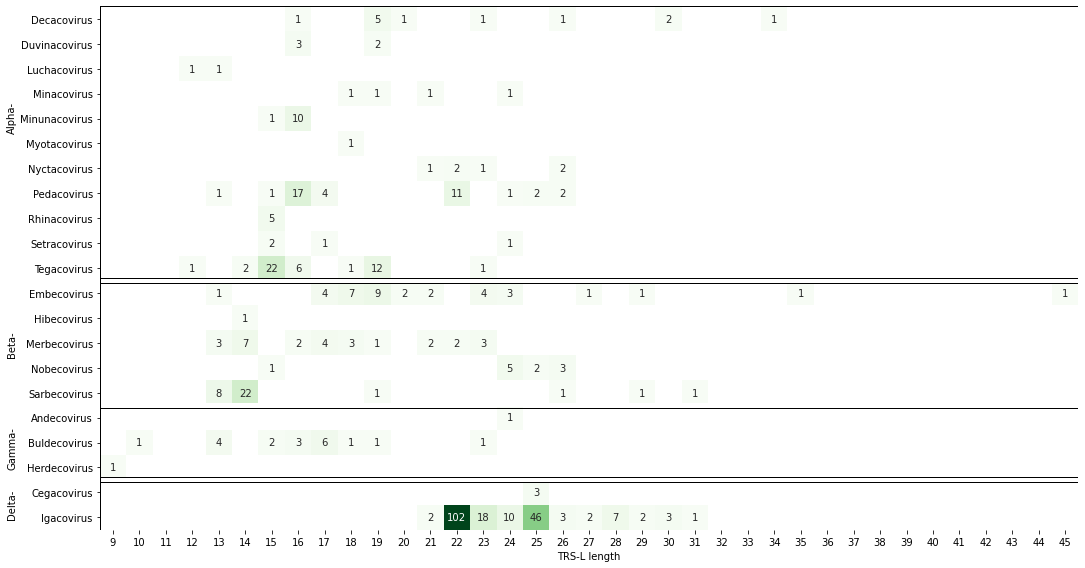

In [23]:
lmin = 9
lmax = 46
length_counts = []
df_trsl = df_corsid_annot.loc[~df_corsid_annot["incomplete"], :]
subgenus_list = df_trsl[["genus", "subgenus"]][~df_trsl[["genus", "subgenus"]].duplicated()].sort_values(["genus", "subgenus"])["subgenus"]
subgenus_list = [s for s in subgenus_list if isinstance(s, str)]
for idx, subgenus in enumerate(subgenus_list):
    if subgenus is None:
        continue
    cnts = df_trsl[df_trsl['subgenus'] == subgenus]['TRS_L'].str.len().value_counts()
    length_counts.append([cnts[x] if x in cnts.keys() else 0 for x in range(lmin, lmax)])
length_counts = pd.DataFrame(length_counts, index=subgenus_list, columns=np.arange(9,46))

fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.heatmap(length_counts, annot=True, xticklabels=True, yticklabels=True, cbar=False, cmap='Greens', mask=np.array(length_counts) == 0, fmt="d")
plt.gca().set_yticklabels(subgenus_list, rotation=0)
plt.gca().set_xticklabels(np.arange(9,46));
plt.gca().set_xlabel('TRS-L length');
plt.tight_layout()

ax.axhline(y=0, color='k',linewidth=1)
ax.axhline(y=np.array(length_counts).shape[0], color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
ax.axvline(x=np.array(length_counts).shape[1], color='k',linewidth=1)
ax.hlines([11-0.1, 11+0.1, 16-0.1, 16+0.1, 19-0.1, 19+0.1], xmin=-1, xmax=37, color="black", linewidth=1)
ax.hlines([11, 16, 19], xmin=-1.1, xmax=37.1, color="white", linewidth=4)
for g, y in {"Alpha-": 5, "Beta-": 14, "Gamma-": 18.5, "Delta-": 20.5}.items():
    ax.text(-3.5, y, g, rotation=90)

In [24]:
df_trsl["TRS_L"].str.len().median()

22.0

## CORSID figures

In [25]:
def get_corsid_df(pattern):
    files = glob.glob(pattern)
    summary = {}
    for file in files:
        sample = file.split("/")[-1].strip().split('.')[0]
        with open(file) as ifile:
            res = json.load(ifile)
            summary[sample] = res
    data = []
    cnt_1ab = 0
    for sample, s in summary.items():
        d = s["results"][0]
        orf1ab_start, _, _, orf1ab_end = s["ORF1ab"]
        orf1ab = gt_orf1ab[sample]
        if orf1ab is not None:
            has_1ab = (orf1ab_start - orf1ab[0] <= 3) and (orf1ab_end - orf1ab[1] <= 3)
        else:
            has_1ab = False
        orfs = [assign_orf(gt_regions[sample], x["ORF_start"], x["ORF_start"] + x["ORF_len"]) for x in d["bodys"]]
        TP = sum(o is not None for o in orfs)
        FP = sum(o is None for o in orfs)
        if has_1ab:
            cnt_1ab += 1
            TP = TP + 1 # TP
            FN = len(gt_regions[sample]) - TP + 1 # FN
            FP = FP # FP
        else:
            TP = TP # TP
            FN = len(gt_regions[sample]) + 1 - TP # FN
            FP = FP + 2 # FP
        data.append([sample, TP, FN, FP, d["weight"], d["leader_core_start"], 1-d["compact"], len(d["leader_core_seq"]), d["leader_core_seq"]])
    print(cnt_1ab)
    df = pd.DataFrame(data, columns=["sample", "TP", "FN", "FP", "max_weight", "leader", "compact", "length", "core_seq"])
    df["gt_leader"] = df_gt_leader.loc[df["sample"], "pos"].values
    df["gt_range_start"] = df_gt_leader_range.loc[df["sample"], "start"].values
    df["gt_range_end"] = df_gt_leader_range.loc[df["sample"], "end"].values
    df["genus"] = df_gt_leader.loc[df["sample"], "genus"].values
    df["subgenus"] = df_gt_leader.loc[df["sample"], "subgenus"].values
    df["dist"] = df["leader"] - df["gt_leader"]
    df["incomplete"] = df["gt_leader"].isna()
    df["correct"] = df["dist"].apply(lambda x: np.NaN if x!=x else abs(x) <= 6)
    df["correct_range"] = df.apply(lambda x: np.NaN if x["incomplete"] else x["gt_range_start"] <= x["leader"] <= x["gt_range_end"], axis=1)
    df["old_correct"] = df.set_index("sample").loc[df["sample"], "correct"].values
    df["precision"] = df["TP"] / (df["TP"] + df["FP"])
    df["recall"] = df["TP"] / (df["TP"] + df["FN"])
    df["F1"] = 2 / (1 / df["precision"] + 1 / df["recall"])
    return df

In [26]:
df_corsid = get_corsid_df("../result/CORSID/*.json")

492


### Prodigal

In [27]:
def orf1ab_correction(df, start, end):
    is_left = False
    is_right = False
    for idx, row in df.iterrows():
        is_left |= abs(row["start"] - start) <= 3
        is_right |= abs(row["end"] - end) <= 3
    return is_left and is_right

def get_prodigal_df(files):
    files = glob.glob(files)
    d_prodigal = {}
    for file in files:
        sample = file.split("/")[-2].strip()
        try:
            with open(file[:-3]+"fasta") as ifile:
                try:
                    offset = int(ifile.readline().split("|")[1].strip())
                except ValueError:
                    offset = 0
        except FileNotFoundError:
            offset = 0
        regions = gt_regions[sample]
        df = pd.read_csv(file,
                         sep='\t',
                         header=None,
                         names=["id", "source", "feature", "start", "end",
                                "score", "strand", "phase", "attributes"],
                         comment='#')
        df.loc[:, ["start", "end"]] += offset
        df["orf"] = df.apply(lambda x: assign_orf(regions, x["start"], x["end"]), axis=1)
        df = pd.concat([df, pd.DataFrame([parse_attributes(a) for a in df["attributes"]])], axis=1)
        d_prodigal[sample] = df
    data = []
    cnt_has_orf1ab = 0
    for sample in d_prodigal.keys():
        df = d_prodigal[sample]
        orf1ab = gt_orf1ab[sample]
        if orf1ab is not None:
            has_orf1ab = orf1ab_correction(df, orf1ab[0], orf1ab[1])
        else:
            has_orf1ab = False
        if has_orf1ab:
            cnt_has_orf1ab += 1
            data.append([sample,
                     df_gt_leader.loc[sample, "genus"],
                     df_gt_leader.loc[sample, "subgenus"],
                     (~df["orf"].isna()).sum() + 1, # TP
                     len(gt_regions[sample]) + 1 - (~df["orf"].isna()).sum() - 1, # FN
                     df["orf"].isna().sum() - 2, # FP
                     df_gt_leader.loc[sample, "pos"],
                    ])
        else:
            data.append([sample,
                         df_gt_leader.loc[sample, "genus"],
                         df_gt_leader.loc[sample, "subgenus"],
                         (~df["orf"].isna()).sum(), # TP
                         len(gt_regions[sample]) + 1 - (~df["orf"].isna()).sum(), # FN
                         df["orf"].isna().sum(), # FP
                         df_gt_leader.loc[sample, "pos"],
                        ])
    df_prodigal = pd.DataFrame(data, columns=["sample", "genus", "subgenus", "TP", "FN", "FP", "gt_leader"])
    df_prodigal["incomplete"] = df_prodigal["gt_leader"].isna()
    df_prodigal["precision"] = df_prodigal["TP"] / (df_prodigal["TP"] + df_prodigal["FP"])
    df_prodigal["recall"] = df_prodigal["TP"] / (df_prodigal["TP"] + df_prodigal["FN"])
    df_prodigal["F1"] = 2 / (1 / df_prodigal["precision"] + 1 / df_prodigal["recall"])
    print(cnt_has_orf1ab)
    return df_prodigal, d_prodigal

In [28]:
df_prodigal, d_assign_prodigal = get_prodigal_df("../result/Prodigal/*/*.gff")

265


### Glimmer3

In [29]:
def get_glimmer_df(files):
    files = glob.glob(files)
    d_glimmer = {}
    for file in files:
        sample = file.split("/")[-2].strip()
        sample = file.split("/")[-2].strip()
        try:
            with open(file[:-7]+"fasta") as ifile:
                try:
                    offset = int(ifile.readline().split("|")[1].strip())
                except ValueError:
                    offset = 0
        except FileNotFoundError:
            offset = 0
        regions = gt_regions[sample]
        df = pd.read_csv(file,
                         sep='\s+',
                         header=None,
                         names=["id", "start", "end", "frame", "score"],
                         comment='>')
        df.loc[:, ["start", "end"]] += offset
        df["orf"] = df.apply(lambda x: assign_orf(regions, x["start"], x["end"]), axis=1)
        d_glimmer[sample] = df
    data = []
    cnt_has_orf1ab = 0
    for sample in d_glimmer.keys():
        df = d_glimmer[sample]
        orf1ab = gt_orf1ab[sample]
        if orf1ab is not None:
            has_orf1ab = orf1ab_correction(df, orf1ab[0], orf1ab[1])
        else:
            has_orf1ab = False
        if has_orf1ab:
            cnt_has_orf1ab += 1
            data.append([sample,
                     df_gt_leader.loc[sample, "genus"],
                     df_gt_leader.loc[sample, "subgenus"],
                     (~df["orf"].isna()).sum() + 1, # TP
                     len(gt_regions[sample]) + 1 - (~df["orf"].isna()).sum() - 1, # FN
                     df["orf"].isna().sum() - 2, # FP
                     df_gt_leader.loc[sample, "pos"],
                    ])
        else:
            data.append([sample,
                         df_gt_leader.loc[sample, "genus"],
                         df_gt_leader.loc[sample, "subgenus"],
                         (~df["orf"].isna()).sum(), # TP
                         len(gt_regions[sample]) + 1 - (~df["orf"].isna()).sum(), # FN
                         df["orf"].isna().sum(), # FP
                         df_gt_leader.loc[sample, "pos"],
                        ])
    df_glimmer = pd.DataFrame(data, columns=["sample", "genus", "subgenus", "TP", "FN", "FP", "gt_leader"])
    df_glimmer["incomplete"] = df_glimmer["gt_leader"].isna()
    df_glimmer["precision"] = df_glimmer["TP"] / (df_glimmer["TP"] + df_glimmer["FP"])
    df_glimmer["recall"] = df_glimmer["TP"] / (df_glimmer["TP"] + df_glimmer["FN"])
    df_glimmer["F1"] = 2 / (1 / df_glimmer["precision"] + 1 / df_glimmer["recall"])
    print(cnt_has_orf1ab)
    return df_glimmer, d_glimmer

In [30]:
df_glimmer, d_assign_glimmer = get_glimmer_df("../result/Glimmer3/*/*.predict")

234


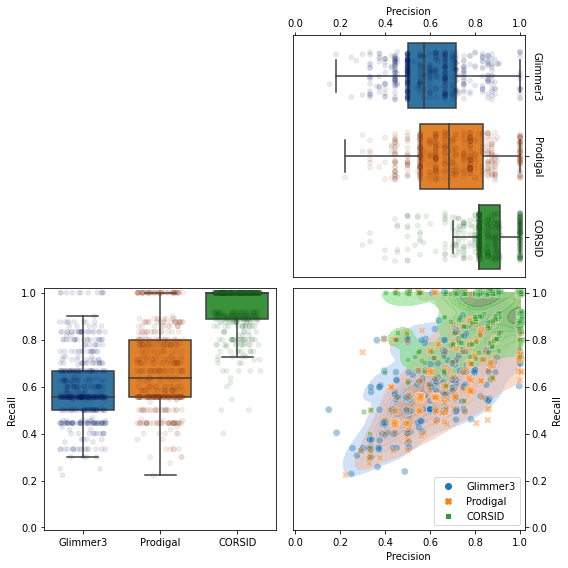

In [31]:
df = df_glimmer
df_combine = pd.concat([pd.DataFrame({
    "sample": df.loc[(~df["incomplete"]), "sample"],
    "recall": df.loc[(~df["incomplete"]), "recall"],
    "precision": df.loc[(~df["incomplete"]), "precision"],
    "F1": df.loc[(~df["incomplete"]), "precision"],
    "genus": df.loc[(~df["incomplete"]), "genus"],
    "method": "Glimmer3"
})], ignore_index=True)
df = df_prodigal
df_combine = pd.concat([df_combine, pd.DataFrame({
    "sample": df.loc[(~df["incomplete"]), "sample"],
    "recall": df.loc[(~df["incomplete"]), "recall"],
    "precision": df.loc[(~df["incomplete"]), "precision"],
    "F1": df.loc[(~df["incomplete"]), "precision"],
    "genus": df.loc[(~df["incomplete"]), "genus"],
    "method": "Prodigal"
})], ignore_index=True)

df = df_corsid
df_combine = pd.concat([df_combine, pd.DataFrame({
    "sample": df.loc[(~df["incomplete"]), "sample"],
    "correct": df.loc[(~df["incomplete"]), "correct"],
    "correct_range": df.loc[(~df["incomplete"]), "correct_range"],
    "recall": df.loc[(~df["incomplete"]), "recall"],
    "precision": df.loc[(~df["incomplete"]), "precision"],
    "F1": df.loc[(~df["incomplete"]), "F1"],
    "genus": df.loc[(~df["incomplete"]), "genus"],
    "method": "CORSID",
})], ignore_index=True)

fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(6, 6)

axes = []
ax = fig.add_subplot(gs[3:, 3:])
axes.append(ax)
sns.kdeplot(
    data=df_combine,
    x="precision",
    y="recall",
    hue="method",
    fill=True,
    levels=7,
    alpha=0.5,
    cut=0,
    legend=False,
    ax=ax,
)
df_combine_jitter = df_combine.copy()
np.random.seed(0)
df_combine_jitter['recall'] = df_combine_jitter['recall'] + 0.005*np.random.randn(len(df_combine_jitter))
df_combine_jitter['precision'] = df_combine_jitter['precision'] + 0.005*np.random.randn(len(df_combine_jitter))
sns.scatterplot(
    data=df_combine_jitter,
    x="precision",
    y="recall",
    hue="method",
    style="method",
    alpha=0.4,
    s=50,
    ax=ax,
)
ax.set_xlim((-.01,1.02))
ax.set_ylim((-.01,1.02))
ax.set_ylabel("Recall")
ax.set_xlabel('Precision')
# ax.set_xticks([])
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position("top")
ax.legend(title=None, loc="lower right")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
# ax.set_aspect('equal', adjustable='box')

ax = fig.add_subplot(gs[:3, 3:])
axes.append(ax)
sns.boxplot(y="method", x="precision", data=df_combine, showfliers=False, orient="h", ax=ax)
sns.stripplot(y="method", x="precision", data=df_combine, jitter=0.3, alpha=.1,
              linewidth=0.5, edgecolor="gray", ax=ax, palette='dark')
ax.set_xlabel("Precision")
ax.set_xlim((-.01,1.02))
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.yaxis.tick_right()
ax.set_yticklabels([t._text for t in ax.yaxis.get_ticklabels()], rotation=-90, va="center")
ax.set_ylabel(None)
ax.yaxis.set_label_position("right")

ax = fig.add_subplot(gs[3:, :3])
axes.append(ax)
sns.boxplot(x="method", y="recall", data=df_combine, showfliers=False, ax=ax)
sns.stripplot(x="method", y="recall", data=df_combine, jitter=0.3, alpha=.1, linewidth=0.5,
              edgecolor="gray", ax=ax, palette='dark')
# ax.set_xticks([])
ax.set_ylabel("Recall")
ax.set_ylim((-.01,1.02))
ax.set_xlabel(None)

for ax in axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
plt.tight_layout()

## BLASTx

In [32]:
df_blastx = {}
df_blastx["CORSID"] = []
for file in ["BLASTx/blastx.corsid.json"]:
    with open(file) as ifile:
        blast_results = json.load(ifile)["BlastOutput2"]
        for i, report in enumerate(blast_results):
            search = report["report"]["results"]["search"]
            if len(search["hits"]) > 0:
                hit = search["hits"][0]
                df_blastx["CORSID"].append([search["query_title"].split('.')[0],
                                  df_gt_leader.loc[search["query_title"].split('.')[0], "genus"],
                                  df_gt_leader.loc[search["query_title"].split('.')[0], "subgenus"],
                                  search["query_title"].split('.')[1],
                                  search["query_len"],
                                  hit["description"][0]["title"],
                                  hit["description"][0]["accession"],
                                  hit["hsps"][0]["query_from"], hit["hsps"][0]["query_to"], 
                                  hit["hsps"][0]["identity"], hit["hsps"][0]["positive"], hit["len"]])
            else:
                df_blastx["CORSID"].append([search["query_title"].split('.')[0], None, None, search["query_title"].split('.')[1],
                                  None, None, None, None, None, None, None, None])
df_blastx["CORSID"] = pd.DataFrame(df_blastx["CORSID"], columns=["sample", "genus", "subgenus", "pos", "qlen", "match", "match_accession",
                                             "qfrom", "qto", "identity", "positive", "len"])
df_blastx["CORSID"]["per_identity"] = df_blastx["CORSID"]["identity"] / df_blastx["CORSID"]["len"]
df_blastx["CORSID"]["per_positive"] = df_blastx["CORSID"]["positive"] / df_blastx["CORSID"]["len"]
df_blastx["CORSID"]["query_cover"] = (df_blastx["CORSID"]["qto"] - df_blastx["CORSID"]["qfrom"] + 1) / (df_blastx["CORSID"]["qlen"] - 3)
df_blastx["CORSID"]

,sample,genus,subgenus,pos,qlen,match,match_accession,qfrom,qto,identity,positive,len,per_identity,per_positive,query_cover
0,NC_023760,Alphacoronavirus,Minacovirus,28128,519.0,hypothetical protein orf7b [Mink coronavirus s...,ADI80520,1.0,516.0,172.0,172.0,204.0,0.843137,0.843137,1.000000
1,NC_023760,Alphacoronavirus,Minacovirus,20312,4326.0,spike protein [Mink coronavirus strain WD1127],ADI80513,10.0,4323.0,1438.0,1438.0,1438.0,1.000000,1.000000,0.997918
2,MH687957,Alphacoronavirus,Pedacovirus,27459,492.0,nonstructural protein NS7 [Scotophilus kuhlii ...,QHA24701,295.0,489.0,49.0,58.0,73.0,0.671233,0.794521,0.398773
3,MH687957,Alphacoronavirus,Pedacovirus,27173,282.0,nucleocapsid protein [Scotophilus kuhlii bat c...,QHA24700,25.0,279.0,79.0,80.0,366.0,0.215847,0.218579,0.913978
4,MH687957,Alphacoronavirus,Pedacovirus,26873,210.0,nucleocapsid protein [Alphacoronavirus sp.],AYR18535,3.0,209.0,69.0,69.0,392.0,0.176020,0.176020,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,KX236008,Gammacoronavirus,Igacovirus,27177,222.0,6b protein [Infectious bronchitis virus],QTC27927,1.0,219.0,71.0,72.0,73.0,0.972603,0.986301,1.000000
875,KX236008,Gammacoronavirus,Igacovirus,25191,285.0,4b protein [Infectious bronchitis virus],QJE49271,1.0,282.0,93.0,93.0,94.0,0.989362,0.989362,1.000000
876,MK472069,Alphacoronavirus,Nyctacovirus,26722,318.0,nonstructural protein 7 [Tylonycteris bat coro...,QCX35165,79.0,315.0,34.0,46.0,119.0,0.285714,0.386555,0.752381
877,MN611520,Betacoronavirus,Merbecovirus,26574,600.0,nonstructural protein NS3c [Pipistrellus abram...,QHA24690,1.0,597.0,199.0,199.0,256.0,0.777344,0.777344,1.000000


In [33]:
df_blastx["glimmer"] = []
for file in ["BLASTx/blastx.glimmer.json"]:
    with open(file) as ifile:
        blast_results = json.load(ifile)["BlastOutput2"]
        for i, report in enumerate(blast_results):
            search = report["report"]["results"]["search"]
            sample, pos = search["query_title"].split('.')
            if df_gt_leader.loc[sample, "pos"] is None:
                continue
            else:
                df = d_assign_glimmer[sample]
                if ~df.loc[df["start"] == pos, "orf"].isna().all():
                    continue
            if len(search["hits"]) > 0:
                hit = search["hits"][0]
                df_blastx["glimmer"].append([sample,
                                  df_gt_leader.loc[search["query_title"].split('.')[0], "genus"],
                                  df_gt_leader.loc[search["query_title"].split('.')[0], "subgenus"],
                                  pos,
                                  search["query_len"],
                                  hit["description"][0]["title"],
#                                   hit["description"][0]["taxid"],
                                  hit["description"][0]["accession"],
                                  hit["hsps"][0]["query_from"], hit["hsps"][0]["query_to"], 
                                  hit["hsps"][0]["identity"], hit["hsps"][0]["positive"], hit["len"]])
            else:
                df_blastx["glimmer"].append([sample, None, None, pos,
                                  None, None, None, None, None, None, None, None])
df_blastx["glimmer"] = pd.DataFrame(df_blastx["glimmer"], columns=["sample", "genus", "subgenus", "pos", "qlen", "match", "match_accession",
                                             "qfrom", "qto", "identity", "positive", "len"])
df_blastx["glimmer"]["per_identity"] = df_blastx["glimmer"]["identity"] / df_blastx["glimmer"]["len"]
df_blastx["glimmer"]["per_positive"] = df_blastx["glimmer"]["positive"] / df_blastx["glimmer"]["len"]
df_blastx["glimmer"]["query_cover"] = (df_blastx["glimmer"]["qto"] - df_blastx["glimmer"]["qfrom"] + 1) / (df_blastx["glimmer"]["qlen"] - 3)
df_blastx["glimmer"]

,sample,genus,subgenus,pos,qlen,match,match_accession,qfrom,qto,identity,positive,len,per_identity,per_positive,query_cover
0,MN514963,Betacoronavirus,Embecovirus,23661,4071.0,S protein [Dromedary camel coronavirus HKU23],QEY10633,1.0,4068.0,1356.0,1356.0,1366.0,0.992679,0.992679,1.000000
1,MN514963,Betacoronavirus,Embecovirus,27721,228.0,4.9 kDa protein [Canine respiratory coronavirus],ACL12997,1.0,132.0,20.0,25.0,44.0,0.454545,0.568182,0.586667
2,MN514966,Betacoronavirus,Embecovirus,23661,4071.0,S protein [Dromedary camel coronavirus HKU23],QEY10657,1.0,4068.0,1356.0,1356.0,1366.0,0.992679,0.992679,1.000000
3,NC_001846,Betacoronavirus,Embecovirus,21759,798.0,non-structural protein 2a [Murine coronavirus],AGT17725,1.0,795.0,265.0,265.0,273.0,0.970696,0.970696,1.000000
4,NC_001846,Betacoronavirus,Embecovirus,22665,1257.0,RecName: Full=Hemagglutinin-esterase; Short=HE...,P31615,1.0,1146.0,382.0,382.0,428.0,0.892523,0.892523,0.913876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,KX998969,Deltacoronavirus,Buldecovirus,5145,6261.0,polyprotein 1a [Porcine deltacoronavirus],QDH76187,1.0,6258.0,2066.0,2073.0,3624.0,0.570088,0.572020,1.000000
1127,KX998969,Deltacoronavirus,Buldecovirus,19330,3462.0,spike protein [Porcine deltacoronavirus],QBF80906,1.0,3459.0,1153.0,1153.0,1160.0,0.993966,0.993966,1.000000
1128,KX998969,Deltacoronavirus,Buldecovirus,23721,246.0,NS6 protein [Porcine deltacoronavirus],APZ76701,1.0,243.0,80.0,80.0,94.0,0.851064,0.851064,1.000000
1129,MK005882,Deltacoronavirus,Buldecovirus,19339,3459.0,spike protein [Porcine deltacoronavirus],QDP14518,1.0,3456.0,1152.0,1152.0,1159.0,0.993960,0.993960,1.000000


In [34]:
df_blastx["prodigal"] = []
for file in ["BLASTx/blastx.prodigal.json"]:
    with open(file) as ifile:
        blast_results = json.load(ifile)["BlastOutput2"]
        for i, report in enumerate(blast_results):
            search = report["report"]["results"]["search"]
            sample, pos = search["query_title"].split('.')
            if df_gt_leader.loc[sample, "pos"] is None:
                continue
            else:
                df = d_assign_prodigal[sample]
                if ~df.loc[df["start"] == pos, "orf"].isna().all():
                    continue
            if len(search["hits"]) > 0:
                hit = search["hits"][0]
                df_blastx["prodigal"].append([sample,
                                  df_gt_leader.loc[search["query_title"].split('.')[0], "genus"],
                                  df_gt_leader.loc[search["query_title"].split('.')[0], "subgenus"],
                                  pos,
                                  search["query_len"],
                                  hit["description"][0]["title"],
#                                   hit["description"][0]["taxid"],
                                  hit["description"][0]["accession"],
                                  hit["hsps"][0]["query_from"], hit["hsps"][0]["query_to"], 
                                  hit["hsps"][0]["identity"], hit["hsps"][0]["positive"], hit["len"]])
            else:
                df_blastx["prodigal"].append([sample, None, None, pos,
                                  None, None, None, None, None, None, None, None])
df_blastx["prodigal"] = pd.DataFrame(df_blastx["prodigal"], columns=["sample", "genus", "subgenus", "pos", "qlen", "match", "match_accession",
                                             "qfrom", "qto", "identity", "positive", "len"])
df_blastx["prodigal"]["per_identity"] = df_blastx["prodigal"]["identity"] / df_blastx["prodigal"]["len"]
df_blastx["prodigal"]["per_positive"] = df_blastx["prodigal"]["positive"] / df_blastx["prodigal"]["len"]
df_blastx["prodigal"]["query_cover"] = (df_blastx["prodigal"]["qto"] - df_blastx["prodigal"]["qfrom"] + 1) / (df_blastx["prodigal"]["qlen"] - 3)
df_blastx["prodigal"]

,sample,genus,subgenus,pos,qlen,match,match_accession,qfrom,qto,identity,positive,len,per_identity,per_positive,query_cover
0,NC_001846,Betacoronavirus,Embecovirus,2,207.0,ORF1a [Murine hepatitis virus],AWB14623,140.0,205.0,21.0,21.0,4496.0,0.004671,0.004671,0.323529
1,NC_001846,Betacoronavirus,Embecovirus,21735,822.0,non-structural protein 2a [Murine coronavirus],AGT17725,1.0,819.0,273.0,273.0,273.0,1.000000,1.000000,1.000000
2,NC_001846,Betacoronavirus,Embecovirus,22665,1257.0,RecName: Full=Hemagglutinin-esterase; Short=HE...,P31615,1.0,1146.0,382.0,382.0,428.0,0.892523,0.892523,0.913876
3,NC_001846,Betacoronavirus,Embecovirus,23899,4005.0,spike protein [Murine hepatitis virus strain A59],ACO72893,31.0,4002.0,1324.0,1324.0,1324.0,1.000000,1.000000,0.992504
4,NC_001846,Betacoronavirus,Embecovirus,27893,486.0,non-structural protein 4 [Murine coronavirus],AGT17717,1.0,483.0,161.0,161.0,161.0,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,KX998969,Deltacoronavirus,Buldecovirus,5145,6261.0,polyprotein 1a [Porcine deltacoronavirus],QDH76187,1.0,6258.0,2066.0,2073.0,3624.0,0.570088,0.572020,1.000000
802,KX998969,Deltacoronavirus,Buldecovirus,23682,285.0,NS6 protein [Porcine deltacoronavirus],APZ76701,1.0,282.0,93.0,93.0,94.0,0.989362,0.989362,1.000000
803,MG812377,Deltacoronavirus,Buldecovirus,19521,3213.0,spike glycoprotein [Sparrow deltacoronavirus],AWV67125,1.0,3210.0,1070.0,1070.0,1157.0,0.924806,0.924806,1.000000
804,MH532440,Deltacoronavirus,Buldecovirus,25022,408.0,NS7b protein [Quail deltacoronavirus],AXP20287,1.0,405.0,135.0,135.0,144.0,0.937500,0.937500,1.000000


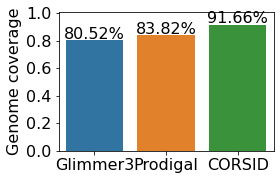

In [35]:
length = 27534 - 20410
def get_compact_score(df, orf1_end, length):
    compact_score = []
    total_length = length - orf1_end
    cov = np.zeros(length)
    for _, row in df.iterrows():
        cov[int(row["pos"]):int(row["pos"])+int(row["qlen"])] += 1
    return (cov>0).sum() / (length - orf1_end)
df = pd.DataFrame([
["Glimmer3", get_compact_score(df_blastx["glimmer"].loc[(df_blastx["glimmer"]["sample"] == "DQ288927") & (df_blastx["glimmer"]["per_positive"] >= 0.95) & df_blastx["glimmer"]["query_cover"] >= 0.95, :], 20410, 27534)],
["Prodigal", get_compact_score(df_blastx["prodigal"].loc[(df_blastx["prodigal"]["sample"] == "DQ288927") & (df_blastx["prodigal"]["per_positive"] >= 0.95) & df_blastx["prodigal"]["query_cover"] >= 0.95, :], 20410, 27534)],
["CORSID", get_compact_score(df_blastx["CORSID"].loc[(df_blastx["CORSID"]["sample"] == "DQ288927") & (df_blastx["CORSID"]["per_positive"] >= 0.95) & df_blastx["CORSID"]["query_cover"] >= 0.95, :], 20410, 27534)],
], columns=["Method", "Genome Coverage"])

# plt.figure(figsize=(4.5*1.3, 4*1.3))
plt.figure(figsize=(4, 2.6))
ax = sns.barplot(data=df, x="Method", y="Genome Coverage", ci=None)
for idx, row in df.iterrows():
    ax.text(idx,
           row["Genome Coverage"]+0.01,
           f"{row['Genome Coverage']*100:.2f}%",
           color='black', ha="center", fontsize=16)
# ax.set_title("TRS-L", fontsize=16)
ax.set(ylim=(0, 1.01))
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
plt.yticks(fontsize=16)
ax.set_ylabel("Genome coverage", fontsize=16)
ax.set_xlabel(None)
plt.tight_layout()

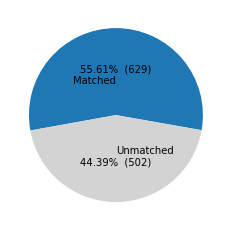

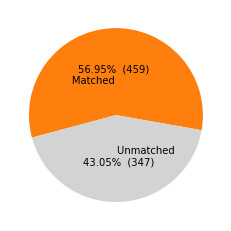

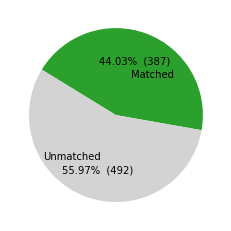

In [36]:
def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            if pct > 50:
                return '\n{p:.2f}%  ({v:d})'.format(p=pct,v=val)
            else:
                return '{p:.2f}%  ({v:d})\n'.format(p=pct,v=val)
        return my_autopct
    
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c',]

dist_list = [0.4, 0.4, 0.5]
labels_list = [["Matched", "Unmatched"],
               ["       Matched", "Unmatched     "],
               ["Matched", "Unmatched"]]
for i, (title, df) in enumerate({
    "Glimmer3": df_blastx["glimmer"],
    "Prodigal": df_blastx["prodigal"],
    "CORSID": df_blastx["CORSID"],
}.items()):
    fig, ax = plt.subplots(1,1)
    passed = len(df[(df["per_positive"]>=0.95) & (df["query_cover"]>=0.95)])
    data = [
        passed,
        len(df) - passed,
    ]
    ax.pie(x=data,
            labels=labels_list[i],
            autopct=make_autopct(data),
            colors=[colors[i], "lightgrey"],
            labeldistance=dist_list[i],
            pctdistance=0.6,
            startangle=-10)

In [37]:
df = df_glimmer
df.loc[~df["incomplete"], ["TP", "FN", "FP"]].sum(), (~df["incomplete"]).sum()

(TP    2395
 FN    1710
 FP    1679
 dtype: int64,
 468)

In [38]:
df = df_prodigal
df.loc[~df["incomplete"], ["TP", "FN", "FP"]].sum(), (~df["incomplete"]).sum()

(TP    2681
 FN    1424
 FP    1235
 dtype: int64,
 468)

In [39]:
df = df_corsid
df.loc[~df["incomplete"], ["correct", "correct_range", "TP", "FN", "FP"]].sum(), (~df["incomplete"]).sum()

(correct           430
 correct_range     443
 TP               3800
 FN                305
 FP                744
 dtype: object,
 468)

Precision: 0.74
Recall: 0.64
Precision: 0.80
Recall: 0.69
Precision: 0.92
Recall: 0.93


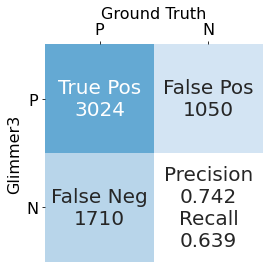

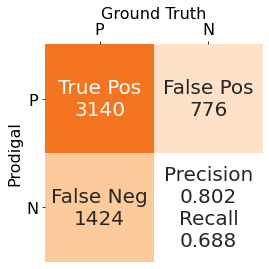

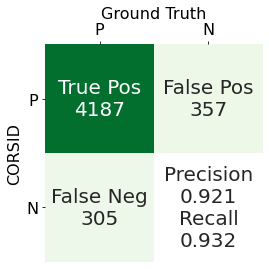

In [40]:
cf_matrix_dict = {'Glimmer3': [[2395+629, 1679-629], [1710, -1]],
                  'Prodigal': [[2681+459, 1235-459], [1424, -1]],
                  'CORSID':   [[3800+387, 744-387], [305, -1]]}
method_colors = ['Blues', 'Oranges', 'Greens']
axes = []
for idx, method in enumerate(['Glimmer3', 'Prodigal', 'CORSID']):
    cf_matrix_dict[method] = pd.DataFrame(cf_matrix_dict[method],
                                          index=pd.Index(["P", "N"],name=method), columns=pd.Index(["P", "N"], name="Ground Truth"))
    precision = cf_matrix_dict[method].loc["P", "P"] / (cf_matrix_dict[method].loc["P", "P"] + cf_matrix_dict[method].loc["P", "N"])
    recall = cf_matrix_dict[method].loc["P", "P"] / (cf_matrix_dict[method].loc["P", "P"] + cf_matrix_dict[method].loc["N", "P"])
    print(f"Precision: {precision:.2f}\nRecall: {recall:.2f}")
    group_names = ['True Pos','False Pos','False Neg','True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix_dict[method].values.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_names,group_counts)]
    labels[-1] = f"Precision\n{precision:.3f}\nRecall\n{recall:.3f}"
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(1,1)
    my_cmap = plt.get_cmap(method_colors[idx]).copy()
    my_cmap.set_under('white')
    ax = sns.heatmap(cf_matrix_dict[method], annot=labels, annot_kws={"fontsize":20},
                    fmt='', cmap=my_cmap, cbar=False,
                    linewidths=0, linecolor='black', vmin = 0, vmax = np.sum(cf_matrix_dict[method].values))
    ax.set_yticklabels(['P','N'], rotation=0, fontsize=16)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.set_aspect('equal', 'box')
    axes.append(ax)

for ax in axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)

Precision: 0.59
Recall: 0.58
Precision: 0.68
Recall: 0.65
Precision: 0.84
Recall: 0.93


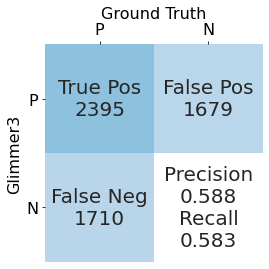

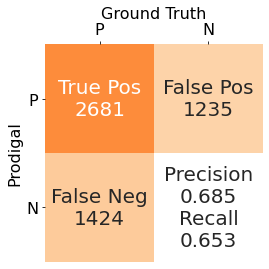

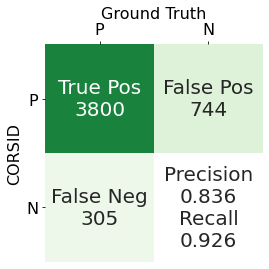

In [41]:
cf_matrix_dict = {'Glimmer3': [[2395, 1679], [1710, -1]],
                  'Prodigal': [[2681, 1235], [1424, -1]],
                  'CORSID':   [[3800, 744], [305, -1]]}
method_colors = ['Blues', 'Oranges', 'Greens']
axes = []
for idx, method in enumerate(['Glimmer3', 'Prodigal', 'CORSID']):
    cf_matrix_dict[method] = pd.DataFrame(cf_matrix_dict[method],
                                          index=pd.Index(["P", "N"],name=method), columns=pd.Index(["P", "N"], name="Ground Truth"))
    precision = cf_matrix_dict[method].loc["P", "P"] / (cf_matrix_dict[method].loc["P", "P"] + cf_matrix_dict[method].loc["P", "N"])
    recall = cf_matrix_dict[method].loc["P", "P"] / (cf_matrix_dict[method].loc["P", "P"] + cf_matrix_dict[method].loc["N", "P"])
    print(f"Precision: {precision:.2f}\nRecall: {recall:.2f}")
    group_names = ['True Pos','False Pos','False Neg','True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix_dict[method].values.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_names,group_counts)]
    labels[-1] = f"Precision\n{precision:.3f}\nRecall\n{recall:.3f}"
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(1,1)
    my_cmap = plt.get_cmap(method_colors[idx]).copy()
    my_cmap.set_under('white')
    ax = sns.heatmap(cf_matrix_dict[method], annot=labels, annot_kws={"fontsize":20},
                    fmt='', cmap=my_cmap, cbar=False,
                    linewidths=0, linecolor='black', vmin = 0, vmax = np.sum(cf_matrix_dict[method].values))
    ax.set_yticklabels(['P','N'], rotation=0, fontsize=16)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.set_aspect('equal', 'box')
    axes.append(ax)

for ax in axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)

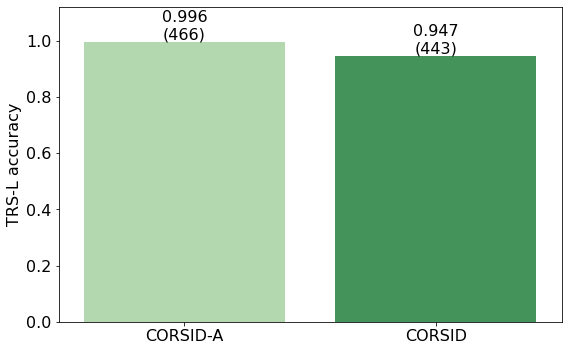

In [42]:
df = df_corsid_annot
df_combine = pd.concat([pd.DataFrame({
    "sample": df.loc[(~df["incomplete"]), "sample"],
    "correct": df.loc[(~df["incomplete"]), "correct"],
    "correct_range": df.loc[(~df["incomplete"]), "correct_range"],
    "recall": df.loc[(~df["incomplete"]), "recall"],
    "precision": df.loc[(~df["incomplete"]), "precision"],
    "F1": df.loc[(~df["incomplete"]), "F1"],
    "genus": df.loc[(~df["incomplete"]), "genus"],
    "method": "CORSID-A",
})], ignore_index=True)

df = df_corsid
df_combine = pd.concat([df_combine, pd.DataFrame({
    "sample": df.loc[(~df["incomplete"]), "sample"],
    "correct": df.loc[(~df["incomplete"]), "correct"],
    "correct_range": df.loc[(~df["incomplete"]), "correct_range"],
    "recall": df.loc[(~df["incomplete"]), "recall"],
    "precision": df.loc[(~df["incomplete"]), "precision"],
    "F1": df.loc[(~df["incomplete"]), "F1"],
    "genus": df.loc[(~df["incomplete"]), "genus"],
    "method": "CORSID",
})], ignore_index=True)

idx = [True] * len(df_combine["sample"])

plt.figure(figsize=(8, 5))
ax = sns.barplot(x="method", y="correct_range", data=df_combine[idx], ci=None, palette="Greens")
grouped = df_combine[idx].groupby("method")
for idx, method in enumerate(x.get_text() for x in ax.get_xticklabels()):
    n_correct = grouped.get_group(method)["correct_range"].sum()
    per_correct = n_correct / len(grouped.get_group(method)["correct_range"])
    ax.text(idx,
           grouped.get_group(method)["correct_range"].mean()+0.01,
           f"{per_correct:.3f}\n({n_correct})",
           color='black', ha="center", fontsize=16)
ax.set(ylim=(0, 1.12))
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
plt.yticks(fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.set_ylabel("TRS-L accuracy", fontsize=16)
ax.set_xlabel(None, fontsize=16)
plt.tight_layout()